# Diffmah Validation
Run Andrew's diffmah model on halos from LJ to explore the smooth mass accretion history of different types of halos (fossils, non-fossils, rugs, etc.) Check whether diffmah provides a good fit to this sample

In [8]:
import copy
import h5py
import pickle
import numba
import numpy as np
import pandas as pd
import seaborn as sns
import haccytrees.mergertrees
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter

from diffmah.diffmah.load_mah_data import load_tng_data, TASSO
from diffmah.diffmah.fit_mah_helpers import get_loss_data
from diffmah.diffmah.fit_mah_helpers import log_mah_mse_loss_and_grads
from diffmah.diffmah.utils import jax_adam_wrapper
from diffmah.diffmah.individual_halo_assembly import _calc_halo_history
from diffmah.diffmah.individual_halo_assembly import _get_early_late

# chronological order (changed on 7/6)
redshifts = np.array([10.044, 9.8065, 9.5789, 9.3608, 9.1515, 8.7573, 8.5714, 8.3925, 8.0541, 7.8938, 7.7391, 7.4454, 7.3058, 7.04, 6.9134, 6.6718, 6.5564, 6.3358, 6.1277, 6.028, 5.8367, 5.6556, 5.4839, 5.3208, 5.2422, 5.0909, 4.9467, 4.7429, 4.6145, 4.4918, 4.3743, 4.2618, 4.1015, 4.00, 3.8551, 3.763, 3.6313, 3.5475, 3.4273, 3.3133, 3.205, 3.102, 3.0361, 2.9412, 2.8506, 2.7361, 2.6545, 2.5765, 2.4775, 2.4068, 2.3168, 2.2524, 2.1703, 2.0923, 2.018, 1.9472, 1.8797, 1.7994, 1.7384, 1.68, 1.6104, 1.5443, 1.4938, 1.4334, 1.3759, 1.321, 1.2584, 1.2088, 1.152, 1.1069, 1.0552, 1.006, 0.9591, 0.9143, 0.8646, 0.824, 0.7788, 0.7358, 0.6948, 0.6557, 0.6184, 0.5777, 0.5391, 0.5022, 0.4714, 0.4337, 0.4017, 0.3636, 0.3347, 0.3035, 0.2705, 0.2423, 0.2123, 0.1837, 0.1538, 0.1279, 0.1008, 0.0749, 0.0502, 0.0245, 0.00])

%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees
plt.rc('figure', facecolor='w')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


### Check redshifts vs. cosmic time values

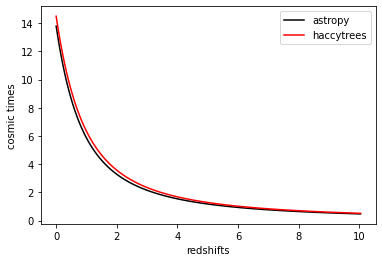

In [9]:
import diffmah
simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
sim_cosmic_times = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))

cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
astro_cosmic_times = cosmo.age(redshifts).value
fig, ax = plt.subplots()
ax.plot(redshifts, astro_cosmic_times, c = "k", label = "astropy") # cosmic time vs timesteps
ax.plot(redshifts, sim_cosmic_times, c = "red", label = "haccytrees")
ax.set_ylabel("cosmic times")
ax.set_xlabel("redshifts")
ax.legend()
fig.savefig("astropy_vs_haccytrees.png")

# Not sure which version to use? Right now I am using astropy

## Load halos and my sample (from pickle jar)

In [10]:
%%time
forest, progenitor_array = haccytrees.mergertrees.read_forest(
    '/data/a/cpac/mbuehlmann/LastJourney/forest/target_forest_aurora.hdf5',
    'LastJourney', nchunks=1, chunknum=0, #mass_threshold = 2.7*10**11,
    include_fields = ["tree_node_mass", "snapnum", "fof_halo_tag", "sod_halo_cdelta", "fof_halo_center_x", "fof_halo_center_y", "fof_halo_center_z", "xoff_fof"]
)

CPU times: user 6.1 s, sys: 10.7 s, total: 16.8 s
Wall time: 16.7 s


In [11]:
%%time
fg_forest, fg_progenitor_array = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney'
)

CPU times: user 22.6 s, sys: 41.9 s, total: 1min 4s
Wall time: 1min 4s


In [12]:
rs_subset = pickle.load(open( "save_rs_subset.p", "rb" ))
fg_subset = pickle.load(open( "save_fg_subset.p", "rb" ))
qh_subset = pickle.load(open( "save_qh_subset.p", "rb" ))

In [7]:
print(rs_subset[0])

89559352


In [13]:
pickled_rs_params = pickle.load( open( "save_new_rs_list.p", "rb" ))
pickled_fg_params = pickle.load( open( "save_new_fg_list.p", "rb" ))
pickled_qh_params = pickle.load( open( "save_new_qh_list.p", "rb" ))

In [10]:
mainbranch_index, mainbranch_mass = help_func_haccytrees.get_branches(86, forest)

1.a.1
1.a.2
1.a.3
1.a.4


### Helper Function

In [19]:
# Calculate their parameters
# For use with a single halo at a time
def fit_halo(data, forest, use_halo_id = True, return_mainbranches = False, lgm_min = np.log10(100*simulation.particle_mass)): #, non_fg_rugs_mrich): # mainbranch_peakmass, size, cosmic_time, min_mass, rs_fg_qh
    """
    Parameters
    ----------
    data: either a set of halo ids (if use_halo_id = True) or the mainbranch_masses of the target halos
    forest: relevant forest of halo trees (i.e. target_forest or fg_forest)
    lgm_min: see get_loss_data() documentation in fit_mah_helpers.py
    
    Returns
    -------
    logt_target: ndarray of shape (nt_fit, )
        Base-10 log of times at which the halo reaches the target masses
        
    log_mah_target: ndarray of shape (nt_fit, )
        Base-10 log of target halo mass # Not sure how exactly this is different from log_mah_fit?
        
    lgtarr: ndarray of shape (nt_fit, )
        Base-10 log of cosmic times of each simulated snapshot in Gyr 
        (this is what is plotted on the x-axis for "diffmah fits")
        
    log_mah_fit: ndarray of shape (n_halos, n_times)
        Base-10 log of cumulative peak halo mass in units of Msun assuming h=1 
        (this is what is plotted on the y-axis for "diffmah fit")
        
    logtc: float
        Base-10 log of transition time (one of the best fit parameters)
    """
    # calculate cosmic times associated with our snapshots (which are in redshifts)
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
    cosmic_times = cosmo.age(redshifts).value
    lgtarr = np.log10(cosmic_times)
    # old way, doesn't include radiation period I guess?
    #t_tng = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps))
    
    if use_halo_id: # Go find the masses yourself
        halo_ids = data
        mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(halo_ids, forest) # np.array around this?
        mainbranch_masses = mainbranch_masses[0]
    else: # just feed in the masses (if you already know them) | make sure they are not log!
        mainbranch_masses = np.array(data)
        
    # Find peakmasses
    mainbranch_peakmass = np.fmax.accumulate(mainbranch_masses, axis=0) # handles nans
    mainbranch_peakmass = np.log10(mainbranch_peakmass)
    mainbranch_peakmass[~np.isfinite(mainbranch_peakmass)] = 0
    
    # Fit diffmah to these halos
    p_init, loss_data = get_loss_data(cosmic_times, mainbranch_peakmass, lgm_min)
    # used to use t_tng instead of cosmic_times
    n_step = 150
    _res = jax_adam_wrapper(log_mah_mse_loss_and_grads, p_init, loss_data, n_step, n_warmup=1)
    p_best, loss, loss_arr, params_arr, fit_terminates = _res
    logtc, ue, ul = p_best
    logt_target, log_mah_target, logt0, k, logmp_fit = loss_data
    early, late = _get_early_late(ue, ul)
    dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late)
    
    if return_mainbranches:
        return logt_target, log_mah_target, lgtarr, log_mah_fit, logtc, mainbranch_masses, mainbranch_peakmass#, logmah_fit_sub
    else:
        return logt_target, log_mah_target, lgtarr, log_mah_fit, logtc

In [8]:
def make_mass_mask(masses, T_FIT_MIN = 1.0, DLOGM_CUT = 2.5):
    """
    Parameters
    ----------
    masses: ndarray of shape (nhalos, nsnapshots) # should come from real data, make sure its log10!
    """
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
    cosmic_times = cosmo.age(redshifts).value
    times_mask = cosmic_times < T_FIT_MIN
    #mask = times_mask & (masses < masses[:,[-1]] - DLOGM_CUT)
    masses[:, times_mask] = np.nan
    mass_mask = masses < masses[:,[-1]] - DLOGM_CUT
    masses[mass_mask] = np.nan
    #masses[mask] = np.nan
    avg = np.nanmean(masses,axis=0)
    std = np.nanstd(masses,axis=0,ddof=1)
    return masses, times_mask, mass_mask

In [9]:
a = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask1 = a > 2
mask2 = a > 6
mask = mask1 & mask2
a[mask2]

array([7, 8])

### diffmah of average vs average of diffmah

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


diffmah of avg
1.2671782 18.500274733748547
avg of diffmah


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


diffmah of avg
0.4043851 2.537377531547281
avg of diffmah


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


diffmah of avg
-0.032872744 0.9271014409821543
avg of diffmah


/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


CPU times: user 35min 8s, sys: 5min 40s, total: 40min 49s
Wall time: 29min 37s


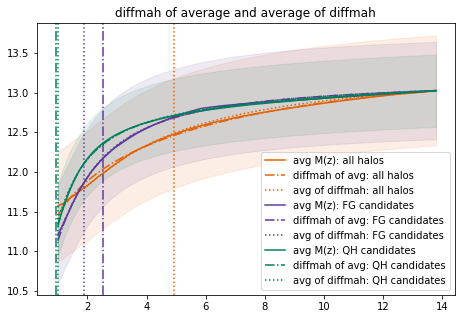

In [28]:
%%time
# find average mass evol history in each category
#colors = [plt.cm.tab10(i) for i in range(n)]
color_labels = ["all halos", "FG candidates", "QH candidates"]
colors = ["#E66100", "#5D3A9B", "#00805D"]
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
cosmic_times = cosmo.age(redshifts).value
times = cosmic_times # redshifts #cosmic_times # redshifts

fig, ax = plt.subplots(figsize=(7.5,5))
for i, (this_subset, this_forest) in enumerate(zip([rs_subset, fg_subset, qh_subset], [forest, fg_forest, fg_forest])):
    
    # Avg M(z)
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(this_subset, this_forest)
    masses, times_mask, mass_mask = make_mass_mask(np.log10(mainbranch_masses))
    #times[times_mask] = np.nan # only look at times that diffmah predicts
    avg_mainbranch_masses = np.nanmean(masses, axis = 0)
    ax.plot(times, avg_mainbranch_masses, color = colors[i], label = "avg M(z): " + color_labels[i])
    
    # diffmah of avg M(z)
    print("diffmah of avg")
    logt_target, log_mah_target, lgtarr, log_mah_fit, logtc = fit_halo(10**avg_mainbranch_masses, this_forest, use_halo_id = False, mask_first = False)
    ax.plot(times, log_mah_fit, linestyle = "-.", color = colors[i], label = "diffmah of avg: " + color_labels[i]) # diffmah fit
    # tau_c of diffmah of avg M(z)
    print(logtc, 10**logtc)
    #tc = z_at_value(cosmo.age, 10**logtc * u.Gyr)
    #ax.axvline(tc, color = colors[i], linestyle = "-.")
    if i != 0:
        ax.axvline(10**logtc, color = colors[i], linestyle = "-.")
    
    # avg of diffmah fits
    print("avg of diffmah")
    log_mah_fit_lst = []
    logtc_lst = []
    for this_halo in this_subset: #[0:100]
        logt_target, log_mah_target, lgtarr, log_mah_fit, logtc = fit_halo(this_halo, this_forest, use_halo_id = True, mask_first = False)
        log_mah_fit_lst.append(log_mah_fit)
        logtc_lst.append(logtc)
    log_mah_fit_arr = np.array(log_mah_fit_lst)
    log_mah_fit_arr[:, times_mask] = np.nan
    log_mah_fit_arr[mass_mask] = np.nan
    #log_mah_fit_sub = np.array(log_mah_fit_lst) #mask_fits(np.array(log_mah_fit_lst)) #np.array(log_mah_fit_lst)
    # mask log_mah_fit using the same mask as for the real data
    avg_log_mah_fit = np.nanmean(log_mah_fit_arr, axis=0)
    std = np.nanstd(log_mah_fit, axis=0, ddof=1)
    ax.plot(times, avg_log_mah_fit, color = colors[i], label = "avg of diffmah: " + color_labels[i], linestyle = ":") # diffmah fit
    ax.fill_between(times, avg_log_mah_fit - std, avg_log_mah_fit + std, alpha = 0.1, color = colors[i]) 
    # tau_c of avg of diffmah fits
    log_tau_c_cosmic_time = np.average(logtc_lst)
    #tau_c = z_at_value(cosmo.age, 10**log_tau_c_cosmic_time * u.Gyr)
    #ax.axvline(tau_c, color = colors[i], linestyle = ":")
    ax.axvline(10**log_tau_c_cosmic_time, color = colors[i], linestyle = ":")
    
#ax.set_ylim(bottom = 10)
ax.set_xlabel(r"cosmic time / Gyr")
ax.set_ylabel(r"$\log_{10}(M(z))$ / h^{-1} \mathrm{M}_\odot")
ax.legend(loc = "lower right")
ax.set_title("diffmah of average and average of diffmah")
fig.savefig("diffmah_checks/various_diffmahs_all_samples_correct_mask_gyr.png")

In [41]:
ax.set_ylim(bottom = 11)
ax.set_ylabel(r"$\log_{10}(M(z))$ / $h^{-1} \mathrm{M}_\odot$")
ax.set_xlabel(r"cosmic time / $Gyr$")
fig.savefig("diffmah_checks/various_diffmahs_all_samples_correct_mask_gyr.png")

## How diffmah works

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


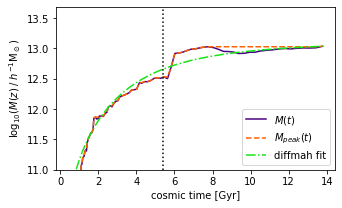

In [95]:
cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
cosmic_times = cosmo.age(redshifts).value

halo_id = rs_subset[72] # 60, 70, 71, 72
my_forest = forest
logt_target, log_mah_target, lgtarr, log_mah_fit, logtc, mainbranch_masses, mainbranch_peakmass = fit_halo([halo_id], my_forest, use_halo_id = True, return_mainbranches = True)

fig, ax = plt.subplots(figsize = (5,3))
ax.plot(cosmic_times, np.log10(mainbranch_masses), linestyle = "-", label = r"$M(t)$", color = "indigo")#color = "#1A85FF")#color = "#15E415")#color = "#058ED9") #color = "mediumorchid")#color = "#058ED9") violet
ax.plot(cosmic_times, mainbranch_peakmass, linestyle = "--", label = r"$M_{peak}(t)$", color = "#FE6100")
ax.plot(cosmic_times, log_mah_fit, linestyle = "-.", label = "diffmah fit", color = "#15E415")#color = "#01B17C")#color = "indigo")#color = "#0FCE0F") # diffmah fit
ax.axvline(10**logtc, color = "black", linestyle = ":")
ax.set_xlabel(r"cosmic time [Gyr]")
ax.set_ylabel(r"$\log_{10}(M(z) \; / \; h^{-1} \mathrm{M}_\odot)$")
ax.set_ylim(bottom = 11)
ax.legend(loc = "lower right")
fig.savefig("diffmah_checks/diffmah_example.png", dpi=300, bbox_inches = "tight")

## Individual Halos

In [12]:
# convert redshifts to cosmic time
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u

def get_fit_from_sample(subset_params):
    logmp_fit, early, late, logtc, __, __, __, __, = subset_params
    simulation = haccytrees.Simulation.simulations['LastJourney'] # read in a chunk of simulation
    cosmo = FlatLambdaCDM(H0=67.77, Om0=0.31)
    cosmic_time = simulation.cosmo.lookback_time(1e-10) - simulation.step2lookback(np.array(simulation.cosmotools_steps)) # perhaps not needed?
    print(redshifts)
    print(cosmic_time)
    cosmic_age = cosmo.age(redshifts).value
    #tarr = np.linspace(0.75, 13.8, 101) # old way
    #lgtarr = np.log10(tarr)
    lgtarr = np.log10(np.flip(cosmic_age)) # Why do we need to flip it exactly?
    k = 3.5 # right?
    dmhdt_fit, log_mah_fit = _calc_halo_history(lgtarr, lgtarr[-1], logmp_fit, logtc, k, early, late)
    print(log_mah_fit)
    return lgtarr, log_mah_fit # not including logt_target, log_mah_target because I can get those (though not smooth)

[10.044   9.8065  9.5789  9.3608  9.1515  8.7573  8.5714  8.3925  8.0541
  7.8938  7.7391  7.4454  7.3058  7.04    6.9134  6.6718  6.5564  6.3358
  6.1277  6.028   5.8367  5.6556  5.4839  5.3208  5.2422  5.0909  4.9467
  4.7429  4.6145  4.4918  4.3743  4.2618  4.1015  4.      3.8551  3.763
  3.6313  3.5475  3.4273  3.3133  3.205   3.102   3.0361  2.9412  2.8506
  2.7361  2.6545  2.5765  2.4775  2.4068  2.3168  2.2524  2.1703  2.0923
  2.018   1.9472  1.8797  1.7994  1.7384  1.68    1.6104  1.5443  1.4938
  1.4334  1.3759  1.321   1.2584  1.2088  1.152   1.1069  1.0552  1.006
  0.9591  0.9143  0.8646  0.824   0.7788  0.7358  0.6948  0.6557  0.6184
  0.5777  0.5391  0.5022  0.4714  0.4337  0.4017  0.3636  0.3347  0.3035
  0.2705  0.2423  0.2123  0.1837  0.1538  0.1279  0.1008  0.0749  0.0502
  0.0245  0.    ]
[ 0.51378868  0.53081295  0.54802002  0.56540789  0.58297456  0.61863675
  0.63672857  0.65499185  0.69202593  0.71079341  0.72972569  0.76807847
  0.78749594  0.82680571  0.8466951

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


[10.044   9.8065  9.5789  9.3608  9.1515  8.7573  8.5714  8.3925  8.0541
  7.8938  7.7391  7.4454  7.3058  7.04    6.9134  6.6718  6.5564  6.3358
  6.1277  6.028   5.8367  5.6556  5.4839  5.3208  5.2422  5.0909  4.9467
  4.7429  4.6145  4.4918  4.3743  4.2618  4.1015  4.      3.8551  3.763
  3.6313  3.5475  3.4273  3.3133  3.205   3.102   3.0361  2.9412  2.8506
  2.7361  2.6545  2.5765  2.4775  2.4068  2.3168  2.2524  2.1703  2.0923
  2.018   1.9472  1.8797  1.7994  1.7384  1.68    1.6104  1.5443  1.4938
  1.4334  1.3759  1.321   1.2584  1.2088  1.152   1.1069  1.0552  1.006
  0.9591  0.9143  0.8646  0.824   0.7788  0.7358  0.6948  0.6557  0.6184
  0.5777  0.5391  0.5022  0.4714  0.4337  0.4017  0.3636  0.3347  0.3035
  0.2705  0.2423  0.2123  0.1837  0.1538  0.1279  0.1008  0.0749  0.0502
  0.0245  0.    ]
[ 0.51378868  0.53081295  0.54802002  0.56540789  0.58297456  0.61863675
  0.63672857  0.65499185  0.69202593  0.71079341  0.72972569  0.76807847
  0.78749594  0.82680571  0.8466951

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


[10.044   9.8065  9.5789  9.3608  9.1515  8.7573  8.5714  8.3925  8.0541
  7.8938  7.7391  7.4454  7.3058  7.04    6.9134  6.6718  6.5564  6.3358
  6.1277  6.028   5.8367  5.6556  5.4839  5.3208  5.2422  5.0909  4.9467
  4.7429  4.6145  4.4918  4.3743  4.2618  4.1015  4.      3.8551  3.763
  3.6313  3.5475  3.4273  3.3133  3.205   3.102   3.0361  2.9412  2.8506
  2.7361  2.6545  2.5765  2.4775  2.4068  2.3168  2.2524  2.1703  2.0923
  2.018   1.9472  1.8797  1.7994  1.7384  1.68    1.6104  1.5443  1.4938
  1.4334  1.3759  1.321   1.2584  1.2088  1.152   1.1069  1.0552  1.006
  0.9591  0.9143  0.8646  0.824   0.7788  0.7358  0.6948  0.6557  0.6184
  0.5777  0.5391  0.5022  0.4714  0.4337  0.4017  0.3636  0.3347  0.3035
  0.2705  0.2423  0.2123  0.1837  0.1538  0.1279  0.1008  0.0749  0.0502
  0.0245  0.    ]
[ 0.51378868  0.53081295  0.54802002  0.56540789  0.58297456  0.61863675
  0.63672857  0.65499185  0.69202593  0.71079341  0.72972569  0.76807847
  0.78749594  0.82680571  0.8466951

/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/home/acossairt/miniconda3/envs/fossil_groups_env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


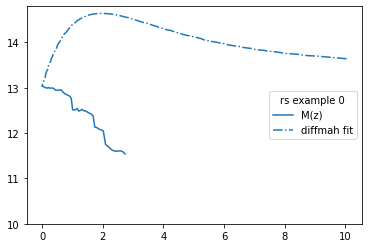

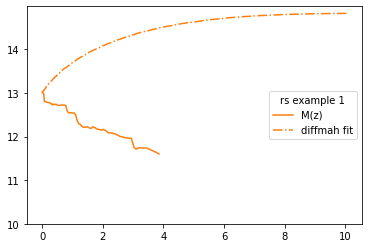

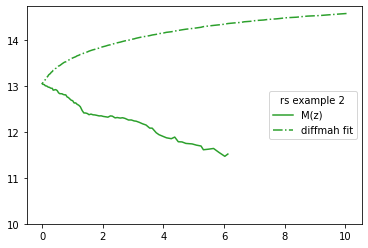

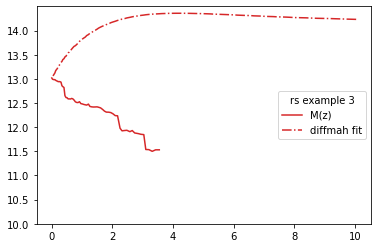

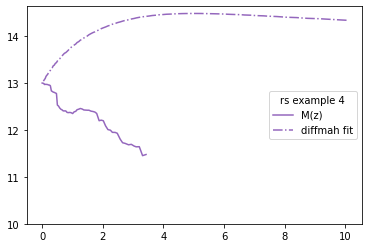

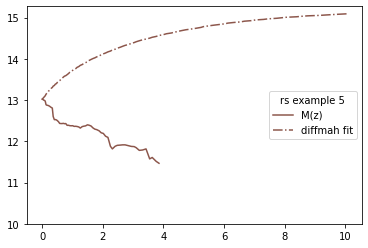

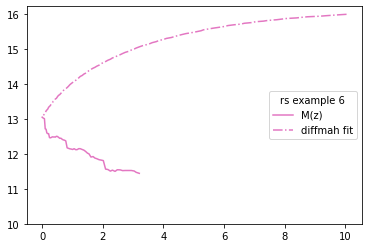

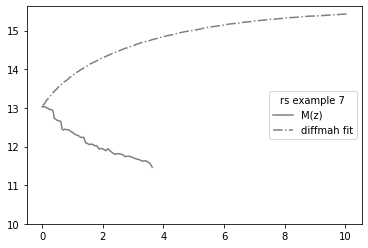

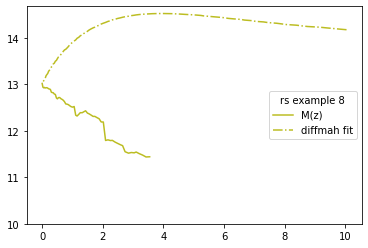

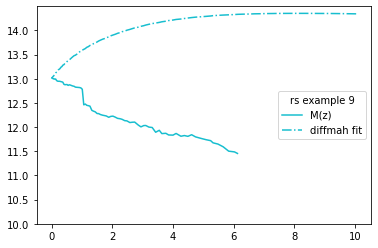

In [13]:
n = 10
category = "rs"
if category == "rs":
    my_subset = rs_subset
    my_forest = forest
    my_params = pickled_rs_params
elif category == "fg":
    my_subset = fg_subset
    my_forest = fg_forest
    my_params = pickled_fg_params
elif category == "qh":
    my_subset = qh_subset
    my_forest = fg_forest
    my_params = pickled_qh_params
    
colors = [plt.cm.tab10(i) for i in range(n)]
mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(my_subset[0:n], my_forest)
for i, params in enumerate(my_params[0:n]): # subset should already be random order
    fig, ax = plt.subplots(1, 1)
    lgtarr, log_mah_fit = get_fit_from_sample(params)
    # how to make redshifts line up with cosmic times?
    ax.plot(redshifts, np.log10(mainbranch_masses[i]), color = colors[i], label = "M(z)")
    ax.plot(redshifts, log_mah_fit, linestyle = "-.", color = colors[i], label = "diffmah fit") # diffmah fit
    ax.set_ylim(bottom = 10)   
    #if i == 0:
    ax.legend(title = category + " example " + str(i), loc = "center right")
    fig.savefig("diffmah_checks/" + category + "_individual_" + str(i) + ".png")
#fig.savefig("diffmah_checks/rs_batch_" + str(n) + ".png")